# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qsim._version import VERSION

VERSION

'ecee69280659edb9a3b415d8fc6e7924cbe0694e'

In [19]:
from qsim.utils.utils import generate_plot_params

generate_plot_params()
from qsim.helpers import *
from qsim.utils.logical_fit import (
    FirstOrder,
    FitAllAtOnce,
)
from qsim.utils.quantum_guidelines import global_setup, plot_setup
global_setup()
from qsim.utils.utils import generate_ax_params

from qsim.logical_gate.phenomenological import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [4]:
num_traj = 40_000
p = 1e-1
q = 2.001e-1
distance = 3
num_neighbours = None
logic_fail_max = 1_000

# Single instance
## check matrix

In [5]:
pheno = CheckMatrixPhenomenological(
    distance=distance, p=p, q=q, verbose=False, logic_fail_max=logic_fail_max
)
print(pheno)
pheno.simulate()

p_exp = pheno._get_results()["state"]["outcome"]["Z"]
num_traje = pheno._get_results()["state"]["num_trajectories"]["Z"]
print(
    f"experimental infidelity proba: {1-p_exp:.3f} +/-"
    f" {error_bar(num_traje, p_exp):.3f}"
)

LGate : CheckMatrixPhenomenological 
	 Distance : 3 
	 Physical Gates : 
 
	num_rounds: 4 
	 Repetition : 4 
	 Max traj : 10000000 
	 Max Logic Fails : 1000 

(d, p, q, r): (3, 0.1, 0.2001, 4)
p=0.1499250374812594 + /- 0.008567593445764313
experimental infidelity proba: 0.150 +/- 0.009


# Threshold curve 

## single fit

In [6]:
distance_l = [i for i in range(3, 12, 2)] + [25, 29, 33]
old_p_l = np.logspace(-3, np.log10(4.9e-1), 41)
p_l = np.concatenate((np.logspace(-5, -3, 31), old_p_l))[::-1]
q_l = old_p_l[15:][::-1]
q_l[3]
distance = 3
num_rounds = distance + 1

In [30]:
def gen_plotting_res(q: float):
    plotting_res = {}
    for distance in distance_l:
        for p in p_l:
            # for q in p_l:
            plotting_res[(p, q, distance, distance + 1)] = {
                "pL": 0.0,
                "N": 0,
                "err": 0,
            }
    return plotting_res


def verify_keys(plotting_res, q):
    for distance in distance_l:
        for p in p_l:
            try:
                assert (p, q, distance, distance + 1) in plotting_res.keys()
            except:
                print((p, q, distance, distance + 1))


def update_plotting_res_from_lgate(plotting_res: dict, q: float, PhenoGate):
    res = search_simulation(
        PhenoGate,
        # distance = param['distance'],
        # p=param['p'],
        q=q,
        # num_rounds = int(param['distance'] * np.log(param['p']) / np.log(param['q']))
        # num_rounds = param['distance']
    )
    for single_res in res:
        distance_res = single_res["distance"]
        num_rounds_res = single_res["num_rounds"]
        p_res = single_res["p"]
        q_res = single_res["q"]
        if (
            num_rounds_res == distance_res + 1
            and p_res in p_l
            and q_res == q
            and distance_res in distance_l
        ):
            p_exp = single_res["state"]["outcome"]["Z"]
            num_traje = single_res["state"]["num_trajectories"]["Z"]

            plotting_res[(p_res, q_res, distance_res, num_rounds_res)][
                "pL"
            ] = p_exp
            plotting_res[(p_res, q_res, distance_res, num_rounds_res)][
                "N"
            ] = num_traje
            plotting_res[(p_res, q_res, distance_res, num_rounds_res)][
                "err"
            ] = error_bar(num_traje, p_exp)
    return plotting_res


def plot_plotting_res(plotting_res: dict, q: float):
    plotting_res_cleaned = remove_null_values(plotting_res)
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    for d in distance_l:
        x, y, yerr = [], [], []
        for p in p_l:
            if (p, q, d, d + 1) in plotting_res_cleaned.keys():
                pL = 1 - plotting_res_cleaned[(p, q, d, d + 1)]["pL"]
                err = plotting_res_cleaned[(p, q, d, d + 1)]["err"]
                if err / pL < 0.3:
                    x.append(p)
                    y.append(pL)
                    yerr.append(err)
        ax.errorbar(
            x,
            y,
            yerr=yerr,
            label=f"$d={d}$",
            marker="+",
            linestyle="",
        )

    ax.axvline(x=0.1094, linestyle=":", label="$p=10.94\%$")
    ax.axvline(x=0.103, linestyle=":", label="$p=10.3\%$", color="grey")
    ax.axvline(x=q, linestyle=":", label="$p=q$", color="green")

    generate_ax_params(
        ax,
        xlabel="$p$",
        title=f"Pheno $q={q:.3f}$",
    )


def remove_null_values(plotting_res):
    return {k: v for k, v in plotting_res.items() if v["pL"] != 0}


def extract_fit(plotting_res: dict, q: float, Fit: Optional[FirstOrder] = None):
    if Fit is None:
        Fit = FirstOrder
    fit = Fit(
        # max_p_L=1e-3
    )
    plotting_res_cleaned = remove_null_values(plotting_res)
    for d in distance_l:
        x, y, yerr = [], [], []
        for p in p_l:
            if (p, q, d, d + 1) in plotting_res_cleaned.keys():
                pL = 1 - plotting_res_cleaned[(p, q, d, d + 1)]["pL"]
                err = plotting_res_cleaned[(p, q, d, d + 1)]["err"]
                N = plotting_res_cleaned[(p, q, d, d + 1)]["N"]
                if pL != 0 and err != 0 and err / pL < 0.3:
                    fit.update(p, d, pL, N)
    fit.validity_regime()
    # print(fit.threshold())
    return fit

In [31]:
%matplotlib inline
# global_setup()

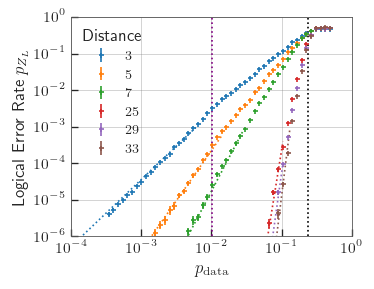

In [35]:
index = 25
plt.close('all')
%matplotlib inline
from qsim.utils.logical_fit import FirstOrder

PhenoGate_l = [
    CheckMatrixPhenomenological,
    CheckMatrixPhenomenological5,
    CheckMatrixPhenomenologicalold,
    CheckMatrixPhenomenological7,
    CheckMatrixPhenomenological29,
    CheckMatrixPhenomenological33,
]
pth_l = []
ptherr_l = []
a_l = []
c_l = []
aerr_l = []
cerr_l = []
# distance_l = range(3, 8, 2)
distance_l = [i for i in range(3, 12, 2)]  + [25, 29, 33]
# distance_l = [i for i in range(3, 8, 2)]

# for q in q_l[index:index+1]:
for i, q in enumerate(q_l):
    # if i in [25]:
        plotting_res = gen_plotting_res(q=q)
        verify_keys(plotting_res=plotting_res, q=q)
        for PhenoGate in PhenoGate_l:
            plotting_res = update_plotting_res_from_lgate(
                plotting_res=plotting_res, q=q, PhenoGate=PhenoGate
            )
        fit = extract_fit(plotting_res=plotting_res, q=q, Fit=FitAllAtOnce)
        fit.per_round = True
        fit.max_p_L = 5e-4
        fit.validity_regime()
        # print(f"max {max([fit.data[k]['pl'] for k in fit.data.keys()])}")
        # fit.plot()
        fit.threshold()
        # print(f"max {max([fit.data[k]['pl'] for k in fit.data.keys()])}")
        if type(fit) == FitAllAtOnce:
            c_l.append(fit.c)
            cerr_l.append(fit.c_err)
        # fit.get_fit_params()
        # plot_plotting_res(plotting_res=plotting_res, q=q)
        if i in [25]:
            ax = fit.plot()
            # print(f"max {max([fit.data[k]['pl'] for k in fit.data.keys()])}")
            ax.set_xlim(1e-4, 1)
            ax.set_ylim(1e-6, 1)

            ax.axvline(q, label=f"$p_{{\\mathrm{{meas}}}}={q:.3f}$", linestyle=":", color="purple")
            ax.axvline(
                fit.pth,
                label=f"$p_{{data, th}}={fit.pth:.3f}$",
                linestyle=":",
                color="black",
            )
            # ax.legend(
            #     # bbox_to_anchor=(1.05, 1),
            #     # loc="upper left"
            # )

            # generate_ax_params(
            #     ax=ax,
            #     title=f"$p_{{meas}}={q:.3f}$ $p_{{data, th}}={fit.pth:.3f}$",
            #     xscale="log",
            # )
            ax.set_xlabel("$p_{\mathrm{data}}$")
            suffix = '_per_round' if fit.per_round else ''
            plt.tight_layout()
            ax.set_title('')
            plt.savefig(f"pheno_{round(q, 3)}_fixed{suffix}.pdf")


        a_l.append(fit.a)
        aerr_l.append(fit.a_err)
        pth_l.append(fit.threshold())
        ptherr_l.append(fit.pth_err)


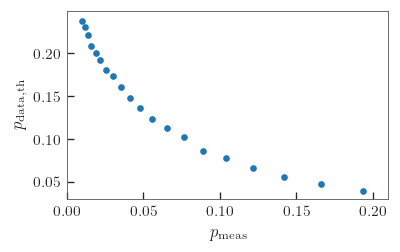

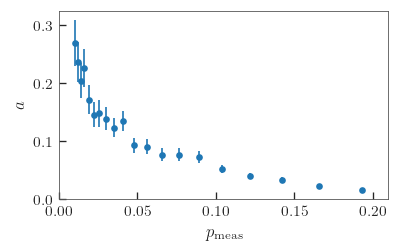

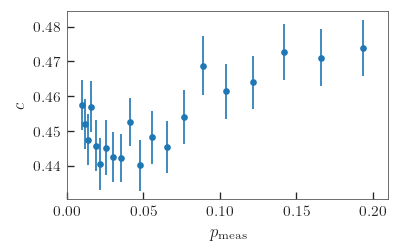

In [36]:

global_setup()
%matplotlib inline
index_max = 0

per_round = True

data_l = [
    pth_l,
    a_l,
    c_l,
]
data_err_l = [
    ptherr_l,
    aerr_l,
    cerr_l,
]

ylabel_l = [
    "$p_{\mathrm{data, th}}$",
    "$a$",
    "$c$",
]

suffix_l = [
    "pth",
    "a",
    "c",
]

index_max = 6
save=True

for i, (data, data_err, ylabel, suffix) in enumerate(zip(data_l, data_err_l, ylabel_l, suffix_l)):
    fig = plot_setup()
    ax = fig.add_subplot()

    ax.scatter(
        q_l[index_max:], data[index_max:],
    )

    ax.errorbar(
        q_l[index_max:], data[index_max:],
        yerr=[1.96 * yerr  for yerr in data_err[index_max:]], # 95% confidence limits
        linestyle="",
    )
    ax.set_xlabel("$p_{\mathrm{meas}}$")
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 0.21)
    plt.tight_layout(pad=0.3)
    # generate_ax_params(ax)
    if save:
        if per_round:
            plt.savefig(f"Pheno_threshold_curve_per_round_{suffix}.pdf", dpi=1000)
        else:
            plt.savefig(f"Pheno_threshold_curve_{suffix}.pdf", dpi=1000)
    plt.show()



In [16]:
df = pd.DataFrame(np.array([q_l, data_l[0], data_err_l[0]]).T, columns=['q', 'pth', 'pth_err'])
df

,q,pth,pth_err
0,0.490000,0.033393,0.000534
1,0.419702,0.033245,0.000529
2,0.359490,0.033072,0.000533
3,0.307915,0.034350,0.000552
4,0.263740,0.027748,0.000163
5,0.225903,0.032283,0.000151
6,0.193494,0.039362,0.000185
7,0.165734,0.047047,0.000219
8,0.141957,0.055801,0.000254
9,0.121591,0.065982,0.000294


In [17]:
df.to_csv('pheno_threshold_curve.csv', index=False)